#**IMPORT MODULES**

In [121]:
import os # paths to file
import scipy # scientific computing
import warnings # warning filter
import numpy as np # linear algebra
import pandas as pd # data processing
import missingno as mso # visualizion for the missing data

# ploting libraries
import matplotlib.pyplot as plt 
import seaborn as sns

# relevant libraries
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# default theme
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

# warning handle
warnings.filterwarnings("ignore")

#**LOADING THE DATA**

In [122]:
# Loading the data from local drives
df_order = pd.read_csv('/content/Order History.csv')
df_feedback = pd.read_csv('/content/Menu Item Feedback.csv')

In [123]:
# Checking the schema structure
df_order.shape

(1089, 38)

We know that we have a total of 1089 rows and 38 columns in our **order history** data set

In [124]:
# Taking a look at all the column names
df_order.columns

Index(['Store', 'External Store ID', 'Country', 'Country Code', 'City',
       'Order ID', 'Order UUID', 'Order Status', 'Delivery Status',
       'Scheduled?', 'Completed?', 'Online Order?', 'Canceled By',
       'Menu Item Count', 'Currency Code', 'Ticket Size', 'Date Ordered',
       'Time Customer Ordered', 'Cancellation Time', 'Time Merchant Accepted',
       'Time to Accept', 'Original Prep Time', 'Prep Time Increased?',
       'Increased Prep Time', 'Courier Arrival Time',
       'Time Courier Started Trip', 'Time Courier Delivered',
       'Total Delivery Time', 'Courier Wait Time (Restaurant)',
       'Courier Wait Time (Eater)', 'Total Prep & Handoff Time',
       'Order Duration', 'Delivery Batch Type', 'Fulfillment Type',
       'Order Channel', 'Eats Brand', 'Subscription Pass', 'Workflow UUID'],
      dtype='object')

In [125]:
# Abbreviated data set (Order Data)
df_order = df_order[['Store', 'Country', 'Country Code', 'City',
       'Order ID', 'Order UUID', 'Order Status',
       'Scheduled?', 'Completed?', 'Canceled By',
       'Menu Item Count', 'Currency Code', 'Ticket Size', 'Date Ordered',
       'Time Customer Ordered', 'Cancellation Time', 'Time Merchant Accepted',
       'Time to Accept', 'Original Prep Time', 'Prep Time Increased?',
       'Increased Prep Time', 'Fulfillment Type', 'Order Channel']]

## Correlation Matrix

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize data, as an input into a more advanced pattern recognition technique.


In [126]:
df_order.columns

Index(['Store', 'Country', 'Country Code', 'City', 'Order ID', 'Order UUID',
       'Order Status', 'Scheduled?', 'Completed?', 'Canceled By',
       'Menu Item Count', 'Currency Code', 'Ticket Size', 'Date Ordered',
       'Time Customer Ordered', 'Cancellation Time', 'Time Merchant Accepted',
       'Time to Accept', 'Original Prep Time', 'Prep Time Increased?',
       'Increased Prep Time', 'Fulfillment Type', 'Order Channel'],
      dtype='object')

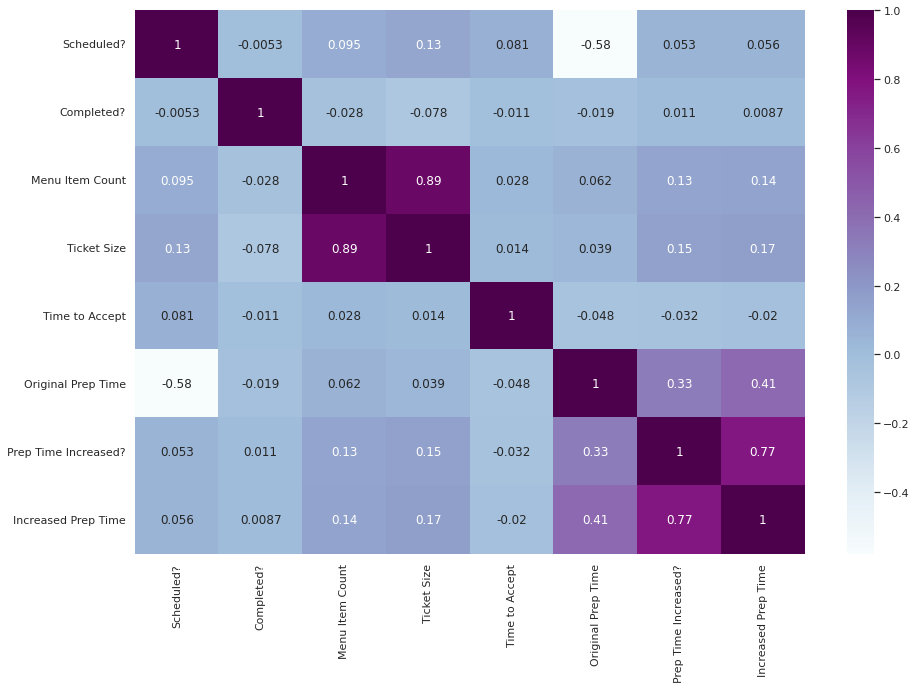

In [127]:
corr = df_order.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot = True, cmap="BuPu")



1.   Ticket Size ($) & Menu Item Count (#) ~ r=0.89
2.   Orders that were not scheduled were cancelled most frequently
3.   Scheduled orders were on average higher up in menu count and amounted to largers sums at the end
4.   Some orders were canceled due to prep time increased (possible to improve this)
5.   As the order count increased so did the prep time and that has reduced the completion rate (risk that is present with larger orders)

In [128]:
# Correlation Table
corr = df_order.corr()
corr.style.background_gradient(cmap="BuPu").set_precision(2)

,Scheduled?,Completed?,Menu Item Count,Ticket Size,Time to Accept,Original Prep Time,Prep Time Increased?,Increased Prep Time
Scheduled?,1.00,-0.01,0.10,0.13,0.08,-0.58,0.05,0.06
Completed?,-0.01,1.00,-0.03,-0.08,-0.01,-0.02,0.01,0.01
Menu Item Count,0.10,-0.03,1.00,0.89,0.03,0.06,0.13,0.14
Ticket Size,0.13,-0.08,0.89,1.00,0.01,0.04,0.15,0.17
Time to Accept,0.08,-0.01,0.03,0.01,1.00,-0.05,-0.03,-0.02
Original Prep Time,-0.58,-0.02,0.06,0.04,-0.05,1.00,0.33,0.41
Prep Time Increased?,0.05,0.01,0.13,0.15,-0.03,0.33,1.00,0.77
Increased Prep Time,0.06,0.01,0.14,0.17,-0.02,0.41,0.77,1.00


In [129]:
# Relabelling the dataframe to relevant data for analysis
df_order = df_order[['Order Status','Menu Item Count','Ticket Size', 'Date Ordered','Time to Accept','Fulfillment Type','Order Channel', 'Original Prep Time']]

In [130]:
# The columns for our new dataframe (cleaned up - section I)
df_order.columns

Index(['Order Status', 'Menu Item Count', 'Ticket Size', 'Date Ordered',
       'Time to Accept', 'Fulfillment Type', 'Order Channel',
       'Original Prep Time'],
      dtype='object')

In [131]:
# Taking a look at the first 25 rows for our new dataframe
df_order.head(25)

,Order Status,Menu Item Count,Ticket Size,Date Ordered,Time to Accept,Fulfillment Type,Order Channel,Original Prep Time
0,completed,2.0,33.50,2022-01-05,0.08,Delivery,iOS,15.00
1,completed,3.0,41.84,2022-01-05,0.13,Delivery,iOS,14.99
2,completed,4.0,36.12,2022-01-05,0.47,Delivery,iOS,14.99
3,completed,9.0,102.26,2022-01-05,0.10,Delivery,Android,15.00
4,completed,2.0,34.55,2022-01-05,0.38,Delivery,Android,14.99
5,completed,5.0,51.77,2022-01-05,0.22,Delivery,Android,12.20
6,completed,5.0,66.94,2022-01-06,0.15,Delivery,iOS,0.00
7,completed,5.0,44.78,2022-01-06,0.17,Delivery,iOS,0.00
8,completed,2.0,21.21,2022-01-06,0.07,Delivery,iOS,14.99
9,completed,4.0,25.41,2022-01-06,0.22,Delivery,iOS,0.00


In [132]:
# Taking a look at the last 25 rows for our new dataframe
df_order.tail(25)

,Order Status,Menu Item Count,Ticket Size,Date Ordered,Time to Accept,Fulfillment Type,Order Channel,Original Prep Time
1064,completed,8.0,62.75,2022-06-25,0.05,Delivery,Android,14.99
1065,completed,3.0,48.14,2022-06-25,0.05,Delivery,iOS,0.07
1066,completed,5.0,68.30,2022-06-25,0.12,Delivery,Web,14.99
1067,completed,4.0,27.95,2022-06-26,1.82,Delivery,iOS,15.00
1068,completed,3.0,22.52,2022-06-26,0.27,Delivery,iOS,15.00
1069,completed,7.0,82.65,2022-06-26,0.32,Delivery,Web,14.99
1070,completed,4.0,40.49,2022-06-26,0.15,Delivery,iOS,14.99
1071,canceled,8.0,103.60,2022-06-26,0.08,Delivery,iOS,14.99
1072,completed,4.0,34.77,2022-06-26,0.13,Delivery,iOS,14.99
1073,completed,3.0,36.12,2022-06-26,0.25,Delivery,iOS,15.00


In [133]:
# statistics for our dataframe
df_order.describe()

,Menu Item Count,Ticket Size,Time to Accept,Original Prep Time
count,1088.000000,1070.000000,1088.000000,1049.000000
mean,4.091912,46.689850,0.181131,13.951983
std,2.017588,24.240791,0.176638,4.140076
min,1.000000,11.290000,0.030000,0.000000
25%,3.000000,30.350000,0.080000,14.990000
50%,4.000000,41.340000,0.130000,14.990000
75%,5.000000,55.612500,0.220000,15.000000
max,19.000000,236.900000,2.720000,50.780000


In [134]:
# Schema structure of the dataframe
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Order Status        1089 non-null   object 
 1   Menu Item Count     1088 non-null   float64
 2   Ticket Size         1070 non-null   float64
 3   Date Ordered        1089 non-null   object 
 4   Time to Accept      1088 non-null   float64
 5   Fulfillment Type    1089 non-null   object 
 6   Order Channel       1089 non-null   object 
 7   Original Prep Time  1049 non-null   float64
dtypes: float64(4), object(4)
memory usage: 68.2+ KB


In [135]:
df_order.value_counts()

Order Status  Menu Item Count  Ticket Size  Date Ordered  Time to Accept  Fulfillment Type  Order Channel  Original Prep Time
canceled      3.0              37.96        2022-06-14    0.05            Delivery          iOS            12.35                 1
completed     4.0              51.56        2022-01-08    0.12            Delivery          Android        14.98                 1
                               59.64        2022-02-11    0.15            Delivery          iOS            0.00                  1
                               60.21        2022-06-17    0.07            Delivery          Web            14.99                 1
                               60.69        2022-01-07    0.15            Delivery          iOS            14.99                 1
                                                                                                                                ..
              3.0              36.12        2022-02-10    0.17            Delivery      

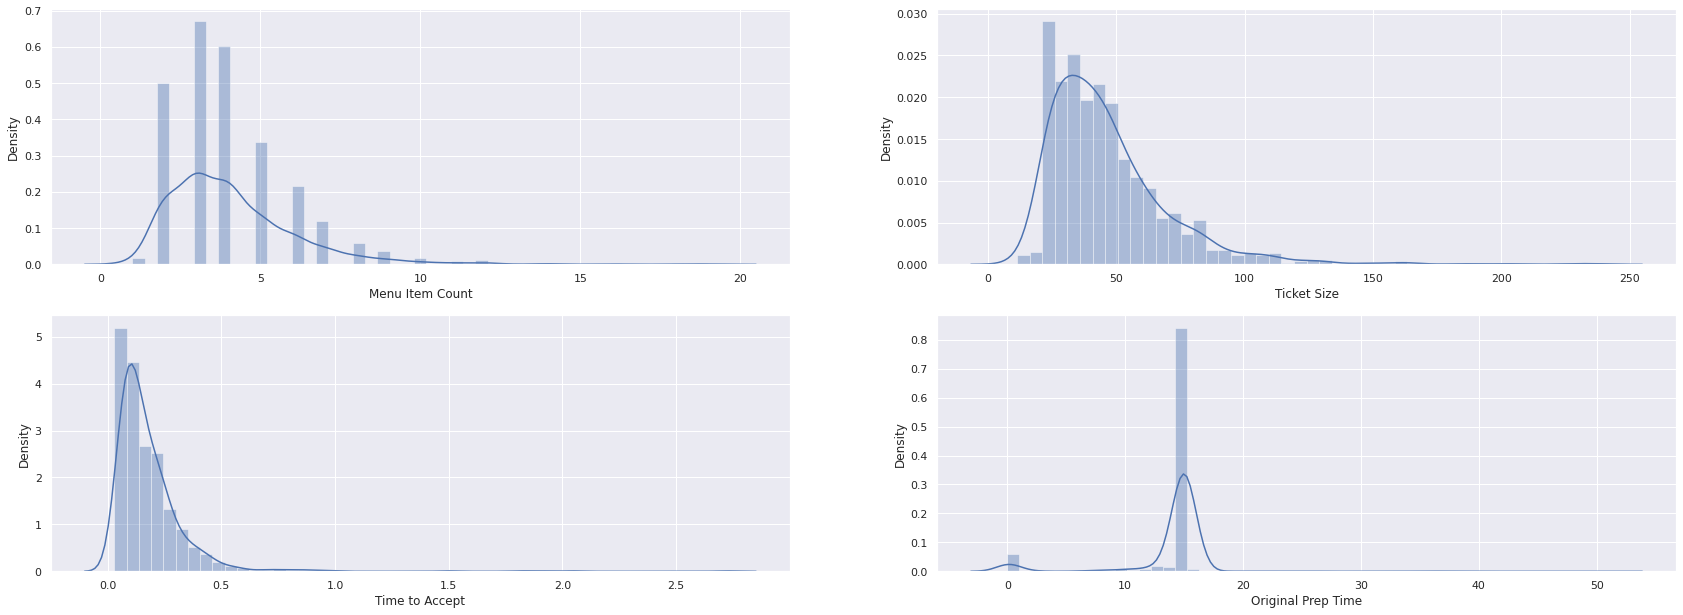

In [136]:
plt.figure(figsize = (45, 16))
sns.set(font_scale = 1)
plt.subplot(331)
sns.distplot(df_order['Menu Item Count'])
plt.subplot(332)
sns.distplot(df_order['Ticket Size'])
plt.subplot(334)
sns.distplot(df_order['Time to Accept'])
plt.subplot(335)
sns.distplot(df_order['Original Prep Time'])

##**EXPLORATORY ANALYSIS**

In [137]:
# Checking if there are any duplicates in our data set
df_order.duplicated().any()

True

In [138]:
# Checking how many duplicates are in our data set
df_order.duplicated().sum()

1

In [139]:
df_order.describe()

,Menu Item Count,Ticket Size,Time to Accept,Original Prep Time
count,1088.000000,1070.000000,1088.000000,1049.000000
mean,4.091912,46.689850,0.181131,13.951983
std,2.017588,24.240791,0.176638,4.140076
min,1.000000,11.290000,0.030000,0.000000
25%,3.000000,30.350000,0.080000,14.990000
50%,4.000000,41.340000,0.130000,14.990000
75%,5.000000,55.612500,0.220000,15.000000
max,19.000000,236.900000,2.720000,50.780000


In [140]:
# Dropping the duplicate rows
df_order.drop_duplicates(inplace=True)

In [141]:
# Checking for null values in our data set
df_order.isnull().sum().sort_values(ascending=False)

Original Prep Time    40
Ticket Size           18
Menu Item Count        1
Time to Accept         1
Order Status           0
Date Ordered           0
Fulfillment Type       0
Order Channel          0
dtype: int64

In [142]:
# Checking how much data is missing from each column
(1 - (df_order.isnull().sum() / df_order.shape[0])) * 100

Order Status          100.000000
Menu Item Count        99.908088
Ticket Size            98.345588
Date Ordered          100.000000
Time to Accept         99.908088
Fulfillment Type      100.000000
Order Channel         100.000000
Original Prep Time     96.323529
dtype: float64

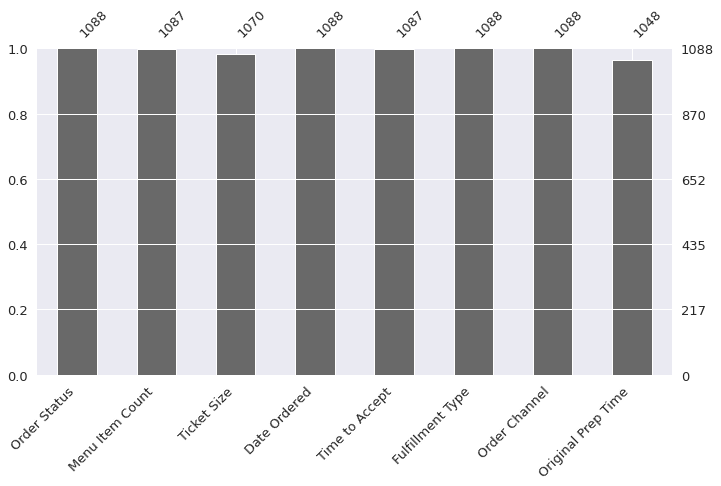

In [143]:
# Getting a visual of how much data is missing
plt.figure(figsize = (25, 6))
lml = plt.subplot(1,2,2)
mso.bar(df_order, ax = lml, fontsize = 13);

In [144]:
df_order.head()

,Order Status,Menu Item Count,Ticket Size,Date Ordered,Time to Accept,Fulfillment Type,Order Channel,Original Prep Time
0,completed,2.0,33.50,2022-01-05,0.08,Delivery,iOS,15.00
1,completed,3.0,41.84,2022-01-05,0.13,Delivery,iOS,14.99
2,completed,4.0,36.12,2022-01-05,0.47,Delivery,iOS,14.99
3,completed,9.0,102.26,2022-01-05,0.10,Delivery,Android,15.00
4,completed,2.0,34.55,2022-01-05,0.38,Delivery,Android,14.99


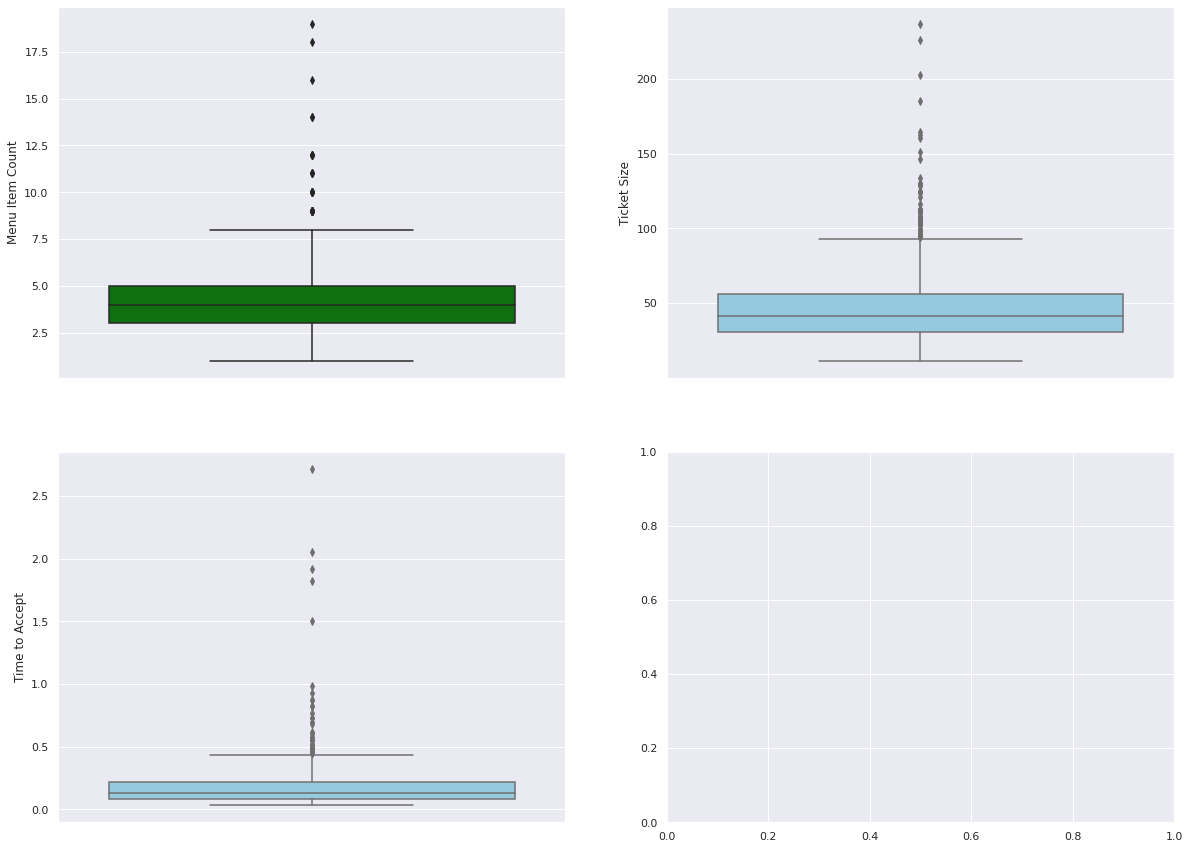

In [145]:
sns.set(style="darkgrid")
fig, axs1 = plt.subplots(2, 2, figsize=(20, 15))

sns.boxplot(data=df_order, y="Menu Item Count", ax=axs1[0, 0], color='green')
sns.boxplot(data=df_order, y="Ticket Size", ax=axs1[0, 1], color='skyblue')
sns.boxplot(data=df_order, y="Time to Accept", ax=axs1[1, 0], color='skyblue')

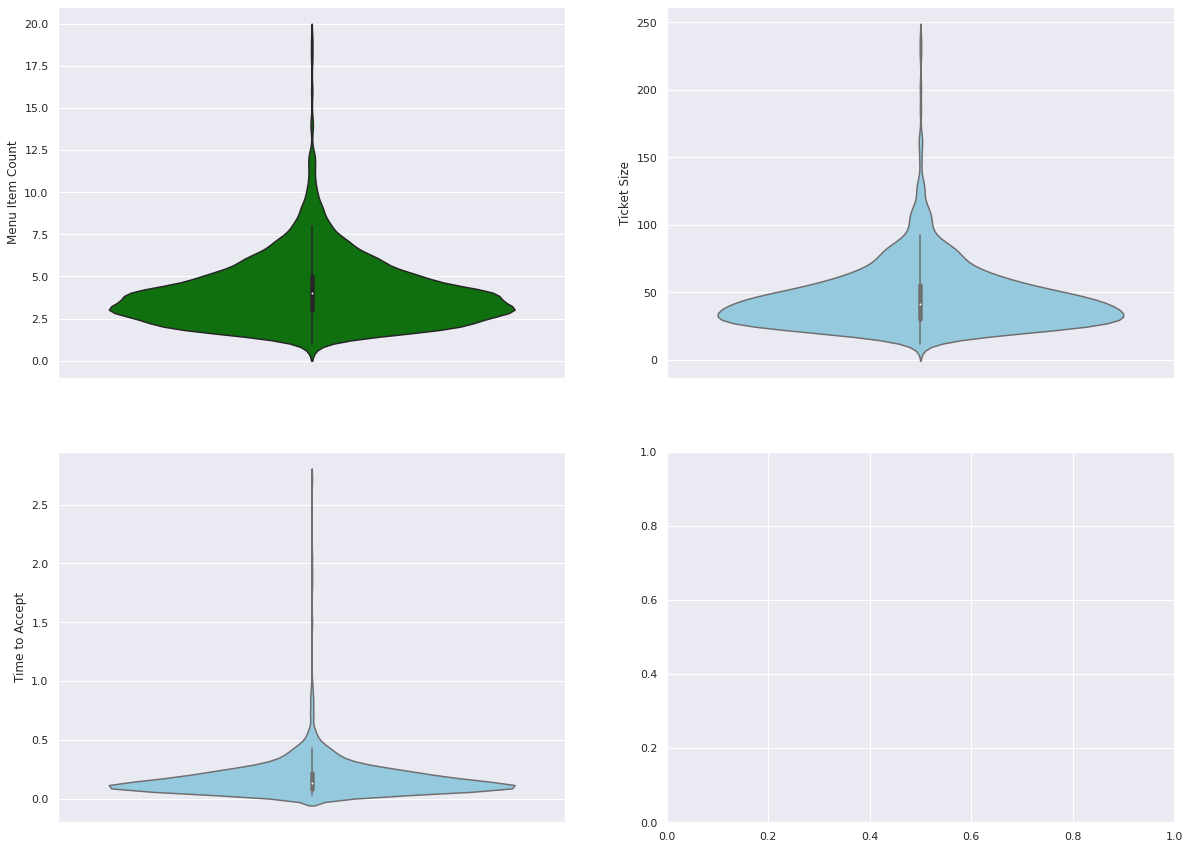

In [146]:
sns.set(style="darkgrid")
fig, axs1 = plt.subplots(2, 2, figsize=(20, 15))

sns.violinplot(data=df_order, y="Menu Item Count", ax=axs1[0, 0], color='green')
sns.violinplot(data=df_order, y="Ticket Size", ax=axs1[0, 1], color='skyblue')
sns.violinplot(data=df_order, y="Time to Accept", ax=axs1[1, 0], color='skyblue')

In [147]:
df_order['Menu Item Count'] = df_order['Menu Item Count'].loc[(df_order['Menu Item Count'] < df_order['Menu Item Count'].quantile(0.90))]
df_order['Ticket Size'] = df_order['Ticket Size'].loc[(df_order['Ticket Size'] < df_order['Ticket Size'].quantile(0.90))]
df_order['Time to Accept'] = df_order['Time to Accept'].loc[(df_order['Time to Accept'] < df_order['Time to Accept'].quantile(0.90))]    

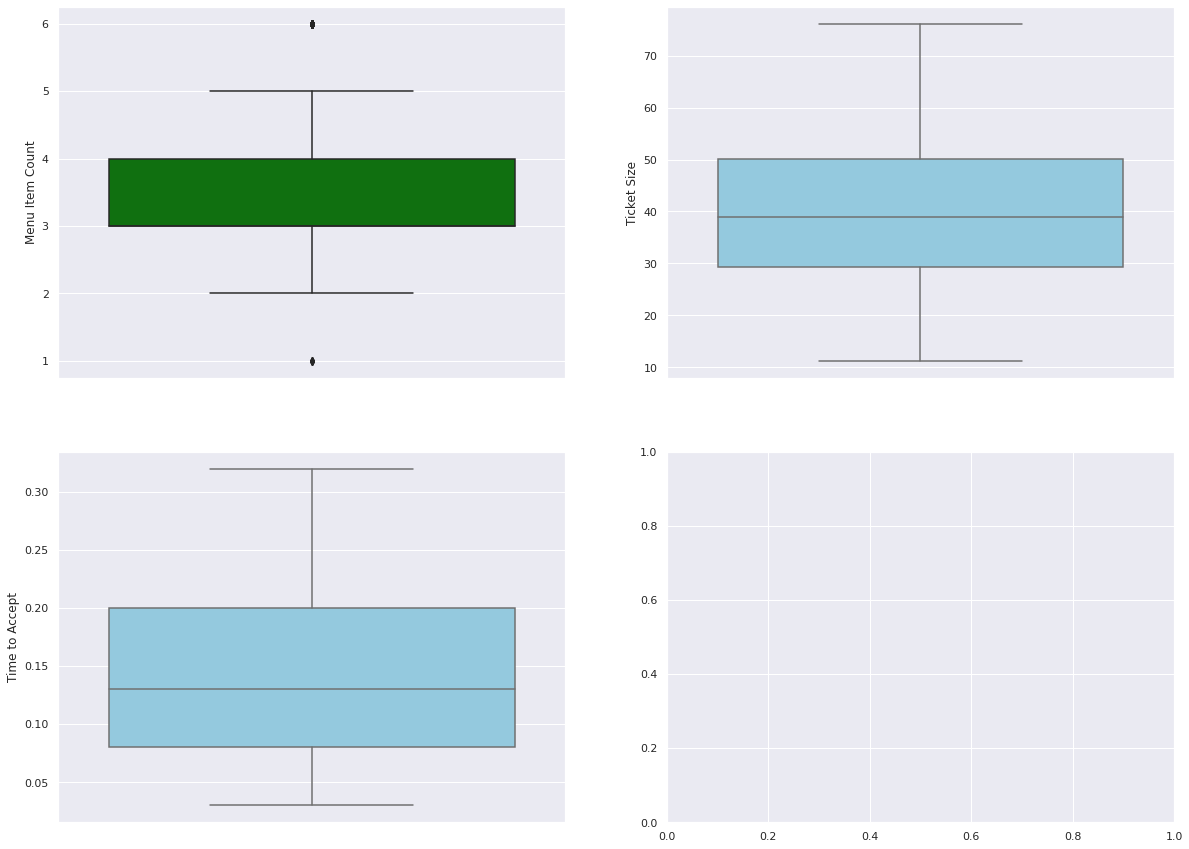

In [148]:
sns.set(style="darkgrid")
fig, axs1 = plt.subplots(2, 2, figsize=(20, 15))

sns.boxplot(data=df_order, y="Menu Item Count", ax=axs1[0, 0], color='green')
sns.boxplot(data=df_order, y="Ticket Size", ax=axs1[0, 1], color='skyblue')
sns.boxplot(data=df_order, y="Time to Accept", ax=axs1[1, 0], color='skyblue')

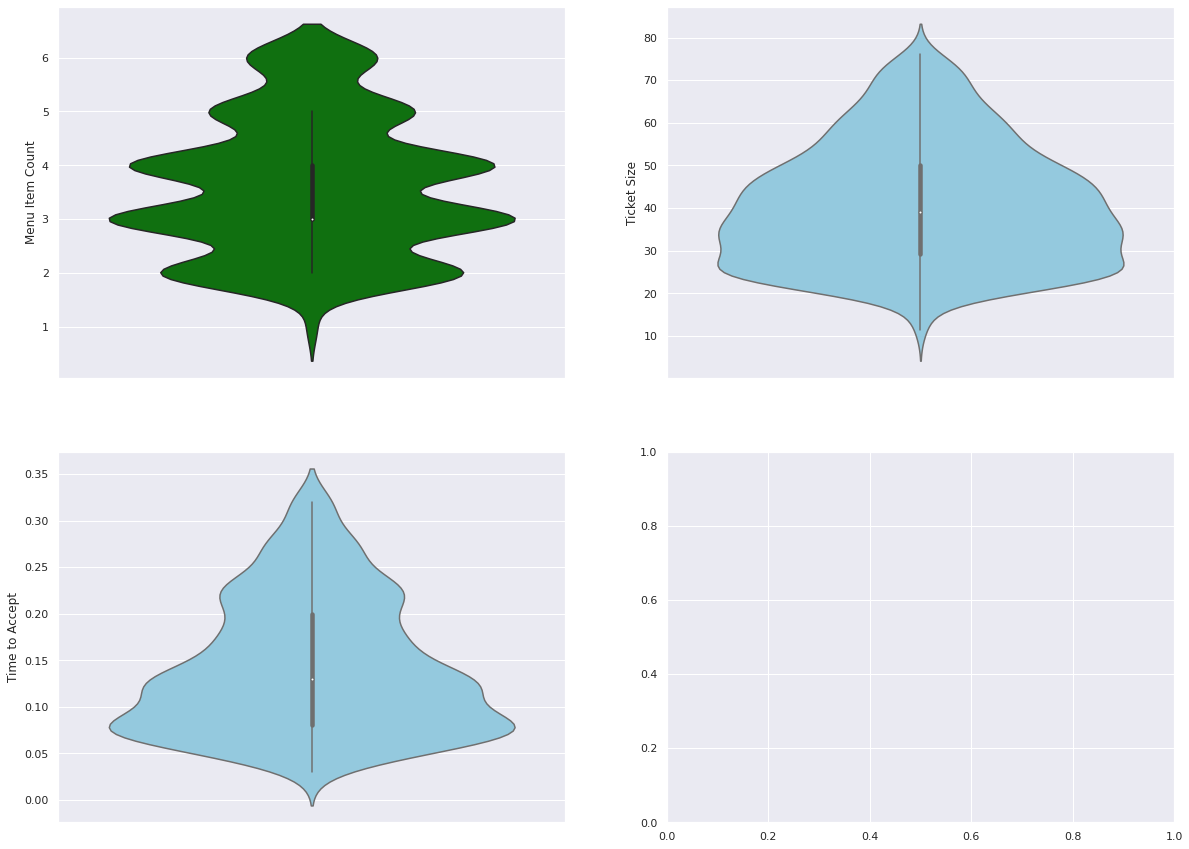

In [149]:
sns.set(style="darkgrid")
fig, axs1 = plt.subplots(2, 2, figsize=(20, 15))

sns.violinplot(data=df_order, y="Menu Item Count", ax=axs1[0, 0], color='green')
sns.violinplot(data=df_order, y="Ticket Size", ax=axs1[0, 1], color='skyblue')
sns.violinplot(data=df_order, y="Time to Accept", ax=axs1[1, 0], color='skyblue')

In [150]:
df_order.describe()

,Menu Item Count,Ticket Size,Time to Accept,Original Prep Time
count,976.000000,963.000000,977.000000,1048.000000
mean,3.595287,40.718660,0.142088,13.951002
std,1.246591,14.045049,0.071391,4.141931
min,1.000000,11.290000,0.030000,0.000000
25%,3.000000,29.300000,0.080000,14.990000
50%,3.000000,39.010000,0.130000,14.990000
75%,4.000000,50.005000,0.200000,15.000000
max,6.000000,76.120000,0.320000,50.780000


##**1) Component Analysis for Order Status**

In [ ]:
plt.figure(figsize = (35, 22))
sns.set(font_scale = 1.5)
plt.subplot(331)
sns.boxplot(x=df_order['Order Status'],y=df_order['Ticket Size'])
plt.subplot(332)
sns.boxplot(x=df_order['Order Status'],y=df_order['Time to Accept'])
plt.subplot(334)
sns.boxplot(x=df_order['Order Status'],y=df_order['Menu Item Count'])
plt.subplot(335)
sns.stripplot(x=df_order['Order Status'],y=df_order['Original Prep Time'])

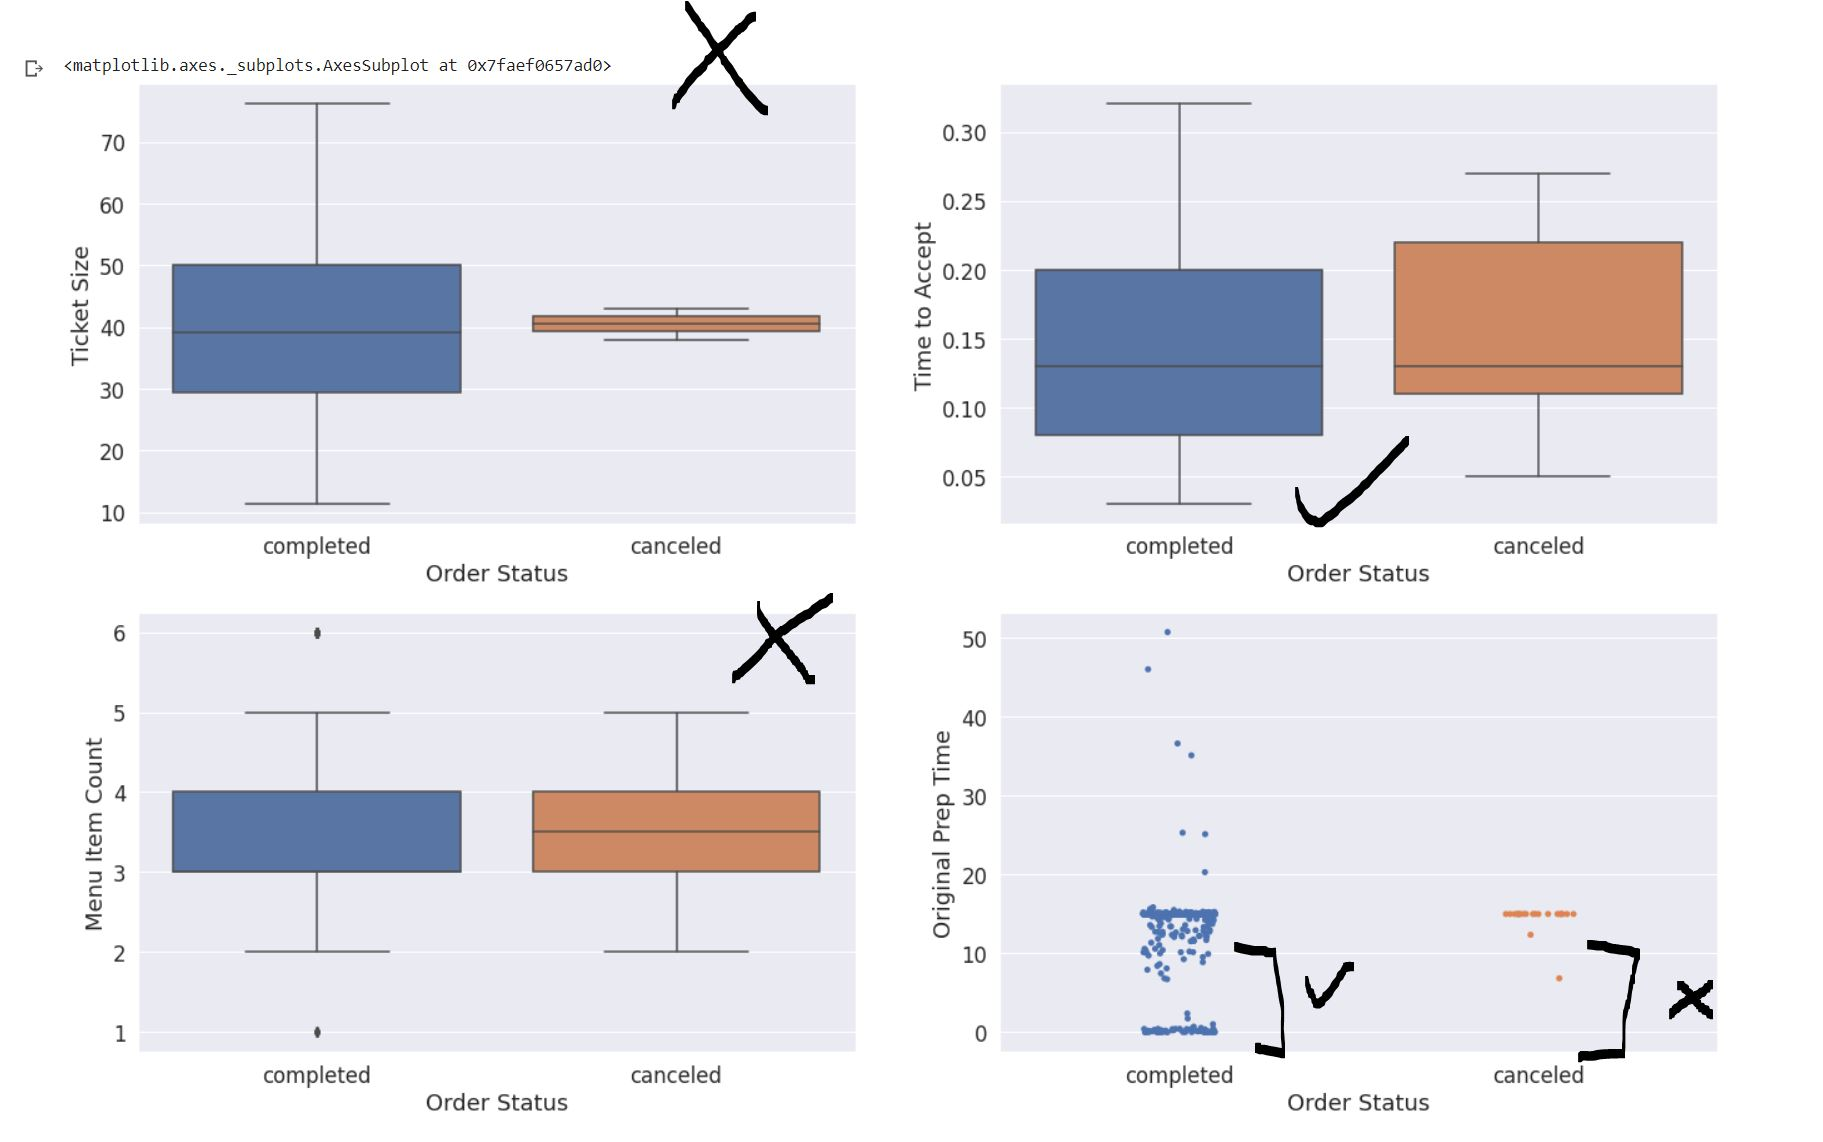



*   There was no significant indication found that the order status was dependent on the ticket size (aka the price of the order).
*   There was also no relationship found that the order status was dependent on the menu count similarly to the price.
*   There was however an indication that orders that were completed were on average accepted much earlier, which reduced the overall cancelation rate for the restaurant. 
*   There was also an indication that the original prep time for the completed orders was significantly lower on average. 



##**2) Component Analysis for Fulfillment Type**

In [ ]:
plt.figure(figsize = (35, 22))
sns.set(font_scale = 1.5)
plt.subplot(331)
sns.stripplot(x=df_order['Fulfillment Type'],y=df_order['Ticket Size'])
plt.subplot(332)
sns.boxplot(x=df_order['Fulfillment Type'],y=df_order['Time to Accept'])
plt.subplot(334)
sns.boxplot(x=df_order['Fulfillment Type'],y=df_order['Menu Item Count'])
plt.subplot(335)
sns.stripplot(x=df_order['Fulfillment Type'],y=df_order['Original Prep Time'])

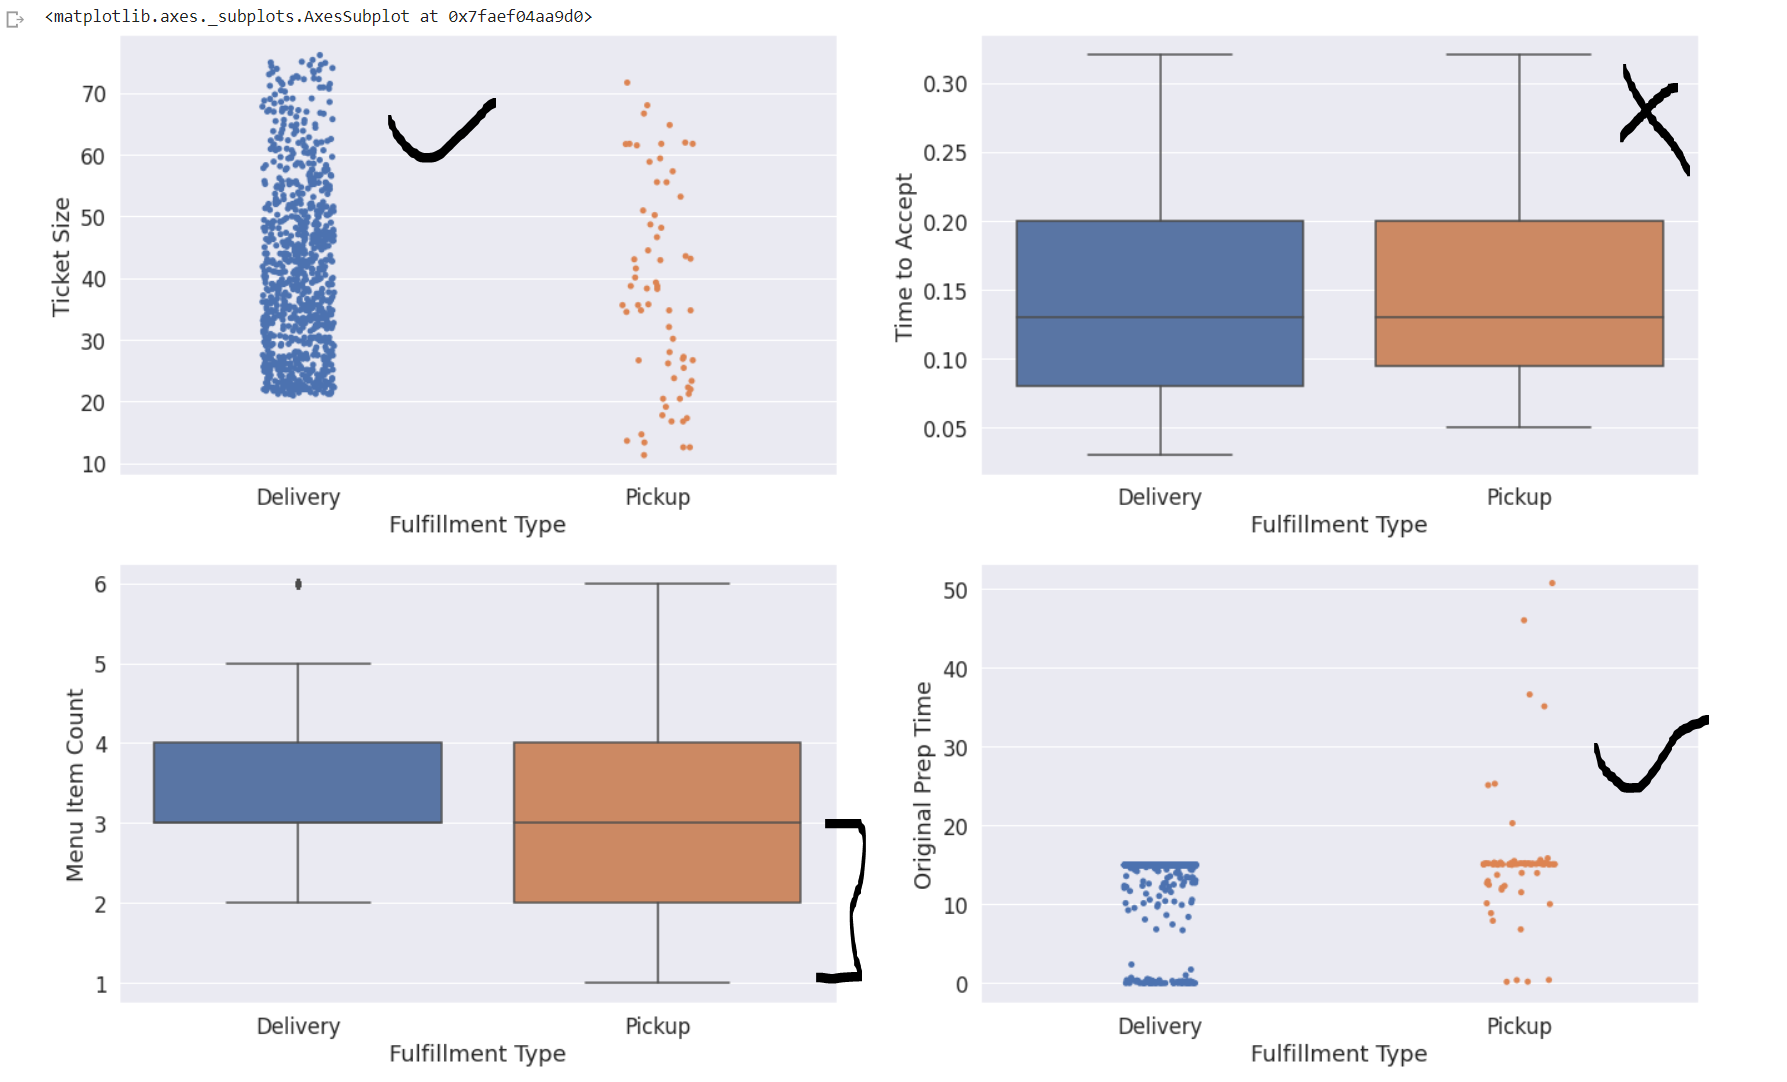



*   By looking at the produced visuals we can quickly see that the orders delivered on average equated to larger ticket sizes. This means that overall as a restaurant you guys make much more off of online orders.  
*   Picked up orders not only equated to fewer amounts spent at the restaurant, but also resulted in fewer items ordered. 
*   There was no significant indication that time to accept an order had any impact on the delivery method opted by the customer. 
*   There was however an indication that the picked up orders took much longer to cook, given that the order was fewer in quantity, and lower in total price when compare to online delivery.



##**3) Component Analysis for Order Channel**

In [ ]:
plt.figure(figsize = (35, 22))
sns.set(font_scale = 1.5)
plt.subplot(331)
sns.stripplot(x=df_order['Order Channel'],y=df_order['Ticket Size'])
plt.subplot(332)
sns.boxplot(x=df_order['Order Channel'],y=df_order['Time to Accept'])
plt.subplot(334)
sns.boxplot(x=df_order['Order Channel'],y=df_order['Menu Item Count'])
plt.subplot(335)
sns.stripplot(x=df_order['Order Channel'],y=df_order['Original Prep Time'])

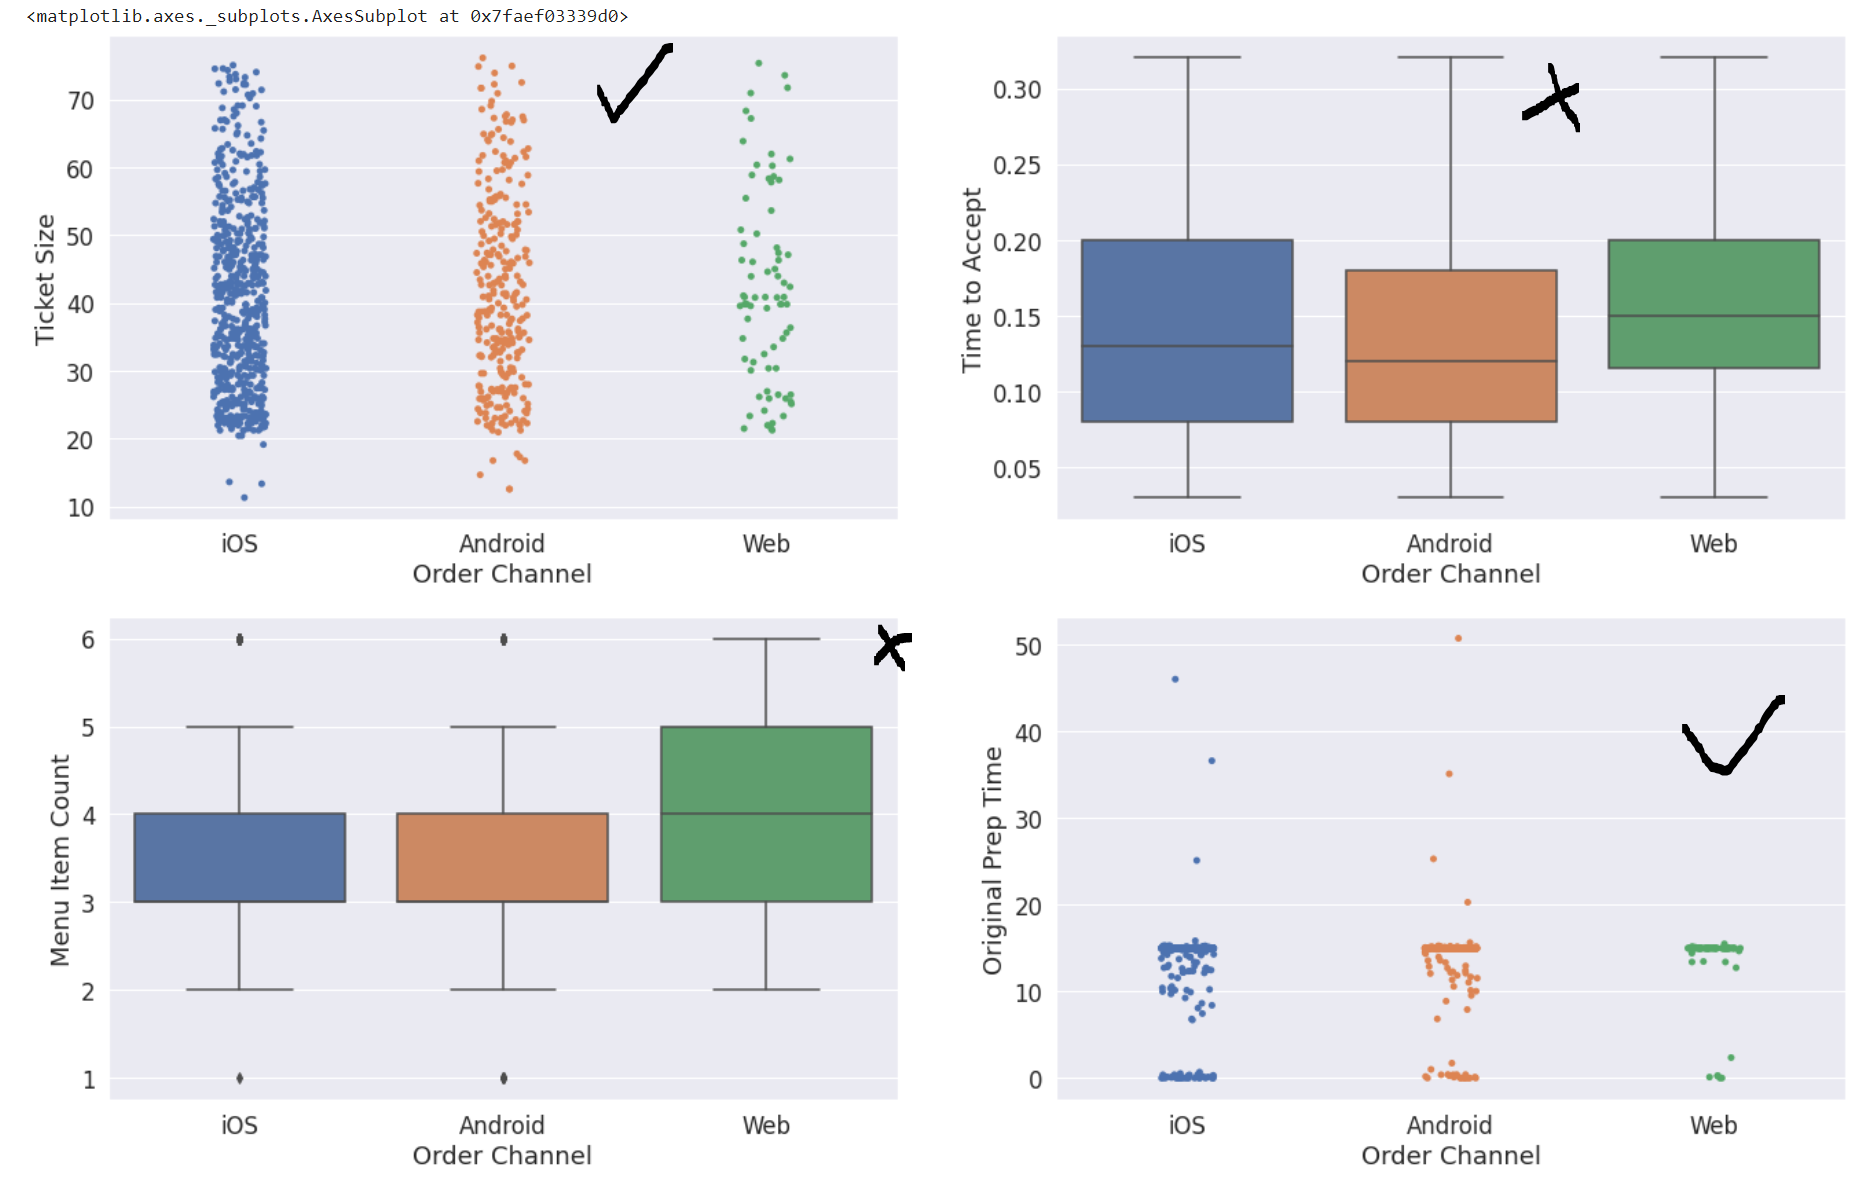



*   From the first visual we can see that majority of your customers are either Android or IOS users, and very few order over the website (this might indicate that the website you guys have is unfavoured due to some elements - hard to navigate, outdated, or errors come up). Statistically speaking it would be beneficial to distribute the spread across all three platforms evenly (principal of diversification - don't put all your eggs in one basket).  
*   Your website users on average order 30% more items from your restaurant when compared to IOS and Android users - this is proven both through menu item count and the ticket size comparison. 
*   There was no signals indicating that channel of delivery impacted the time to accept an order. 
*   There was however a relationship between prep time and channel used for delivery, orders from the website users took less time to cook, equated to larger amounts spent, and more items ordered. 



##**4) Component Analysis for Menu Item Count**

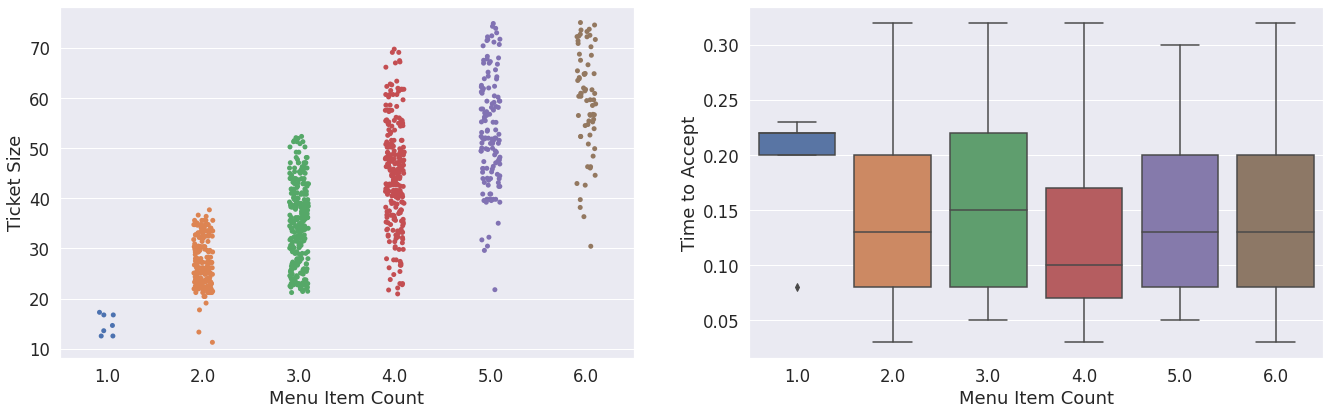

In [162]:
plt.figure(figsize = (35, 22))
sns.set(font_scale = 1.5)
plt.subplot(331)
sns.stripplot(x=df_order['Menu Item Count'],y=df_order['Ticket Size'])
plt.subplot(332)
sns.boxplot(x=df_order['Menu Item Count'],y=df_order['Time to Accept'])



*   We see there is great proportionality between menu item count and ticket size, meaning the more items people order, the more they spend on average (which makes sense logically).
*   We notice an interesting relationship between menu item count and time it takes to accept an order... the higher the menu item count, the larger the ticket size (price), and the larger the price, the lesser time it takes to accept an order. 



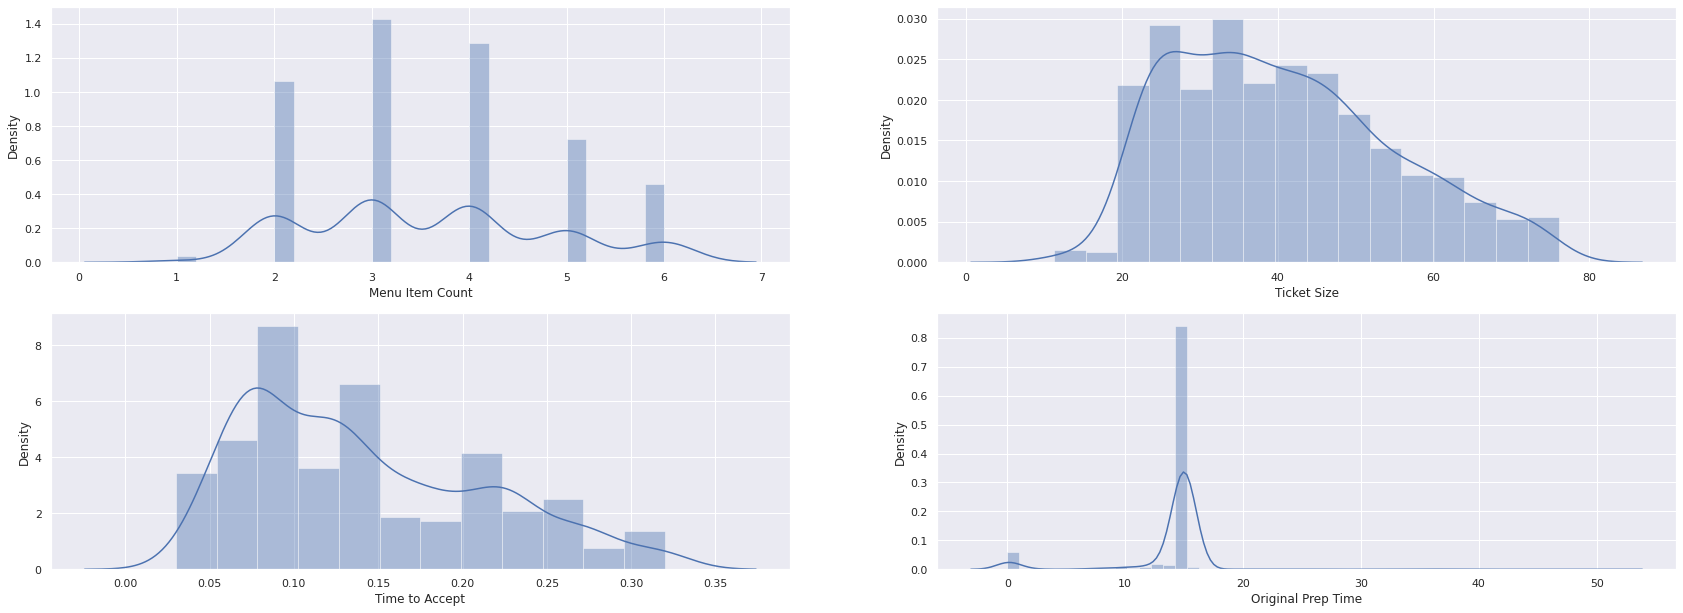

In [160]:
plt.figure(figsize = (45, 16))
sns.set(font_scale = 1)
plt.subplot(331)
sns.distplot(df_order['Menu Item Count'])
plt.subplot(332)
sns.distplot(df_order['Ticket Size'])
plt.subplot(334)
sns.distplot(df_order['Time to Accept'])
plt.subplot(335)
sns.distplot(df_order['Original Prep Time'])







1.   Scheduled orders are correlated with both menu item count and ticket size, this means that by luring people to book ahead you can significantly up your revenue year over year. This might be because many scheduled occasions are some sort of celebrations (whether it is a birthday dinner or a date night) meaning that having these occasions more often at your restaurant would significantly improve your revenue. Scheduled orders are also inversely correlated with the original prep-time. Scheduled orders probably get prepared ahead of time which saves people the effort of waiting.    


---


2.   We can also notice a significant correlation between ticket size and increased prep-time. 
The reasoning for this may be that the customers gain more appetite with the anticipation of their food delivery and order more. However, a more likely reasoning for this correlation is that the larger orders usually have a higher chance of being delayed. This delay has also shown to negatively reflect on your review ratings. A take away for your business regarding this component is to reduce the prep-time or make a more conservative estimation so that the delay would not be necessary, it's better to lower the expectation for the customer and beat it rather than set the expectation high and fail to achieve it.   


---


3.   We also notice that the unscheduled orders were the most canceled orders on average. This makes sense practically speaking because anytime people call for a reservation or book a pick-up, they have something coming up. A good encouragement for your business could be to motivate the consumers to order ahead of time and to offer a discount for such orders. This will not only incentivise the public to buy from you more frequently, but also encourage them to do so ahead of time. With this you are also guaranteeing to deliver the order on time, which significantly increases your chances of receiving a better review after the order is complete. 


---


4.   The strongest and most obvious correlation above all is definitely the one between the menu item count and the ticket size. The higher the menu count, the more the customer pays to the restaurant. Increasing the menu component for bundles or package options could significantly help you generate more revenue as the customer would increase their average spend at your restaurant.    


